# Compute Phase using Iterative Relative Phase Measurements
#### Ben Nativi with Professor Calderbank

The goal of this program is to find the eigenbases for the maximal commutative subgroups Sa and Ta for the Heisenberg-Weyl Group $HW_N$ given some choice of binary tuple a of length m.

This version of the program relies on an algorithm designed by Trung Can.

### Useful np functions
np.array( [ [], [] ] )

np.matmul(matrix1, matrix2)

np.kron(matrix1, matrix2)

np.transpose(matrix)

np.linalg.eig(matrix) outputs: eigenvalue array, normalized eigenvector array 
https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.linalg.eig.html

numpy.diag(v, k=0)[source] 
https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.diag.html

numpy.identity(m)

numpy.zeros( (m,m) )

# Helper Functions

The list of helper functions is:

reverseBin(binary)

intToBin(num,N)

binToInt(binary)

xorInt(one, two)

--------------------
D(a,b)

E(a,b)

createOmega_a(aBin,N)

createNOmega_a(aBin,N)

--------------------
validA(a,m)

--------------------
sympInProd(a,b,m)

makeHN(m)

makeIN(m)

--------------------
getQSa(a,m)

getPSa(a,m)

getPTa(a,m)

--------------------
diagTP(P,m)

permQ(Q,m)

getGk(k,m)

-------------------
check(one, two)

cleanUp(matrix)

cleanUp2(matrix)

roundComplex(complexNum)

-------------------
getSaTaBases(a,m)

-------------------
sympTP(P,m)

sympAQ(Q,m)

sympGk(k,m)

get_c(aBin,bBin,m,G)

-------------------
extra(aBin,bBin)

buildEigvalMat(a,m)

buildEigvec(x,a,m) - no longer needed

relativePhase(x,a,m) - no longer needed

check3(vec1,vec2)

getPhase(vec) - no longer needed

-------------------
complexRandomNoise(deviation)

generateX(size,magnitude)

buildEigvecNoise(x,a,m,deviation)

relativePhaseNoise(x,a,m,deviation)

getPhaseNoise(x,deviation)

testAlgForVariance(trials,size,magnitude,deviation)

testRelPhasForVariance(trials,m,magnitude,deviation)

-------------------
getPhaseNoiseOpt(x,deviation)

testOptAlgCorrectness(trials,size,magnitude,deviation)

testOptAlgForVariance(trials,size,magnitude,deviation)

-------------
### NOTE
#### mean squared error only depends on the ratio mag^2/dev
For a given ratio, the mean squared error always follows the same pattern.  For the original algorithm, the mean squared error increases by 30-50% with each increment of m, and with optimized algorithm (modifying signal), the mean squared error increases by 5-10% with each increment increasing m.

Also the optimized algorithm in all cases performes approximately 3x better than the original algorithm.

In [1]:
#imports

# Tell Python to include plots as embedded graphics.
%matplotlib inline

# Import plotting, numpy, and library commands
import matplotlib.pyplot as plt
import numpy as np
import math
import random as r
from tqdm import tqdm_notebook as tqdm
import time
from collections import deque
r.seed(1717)
np.random.seed(1717);

font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

from scipy.stats import chisquare

import sympy # for finding linearly independent rows to get generating set

import itertools # used for combinations and permutations

In [2]:
# methods used for phase recovery
from utils.binary_operations import *
from utils.random import *

from utils.heisenberg_weyl_methods import *
from utils.relative_phase import *
from utils.relative_phase_noise import *

from utils.get_phase_original_noiseless import *
from utils.get_phase_original_noise import *
from utils.get_phase_ASMT import *
from utils.get_phase_bipartite import *

from utils.test1 import *
from utils.test2 import *
from utils.simulations1 import *

In [3]:
run = 0 #testing get_phase_original and get_phase_noise
if run:
    for i in range(10):
        x = generate_x_uniform(16, 100000)
    #     print(x)
        x_hat = get_phase_noise(x,0.001)
    #     print(x_hat)
        check3(x,x_hat)

In [4]:
#Test code for get_phase_noise

run = 0 #controls whether the test code runs, set to 1 to run this code

if (run):
    deviation = 0.1
    #test 1
    x = [ 2, -1, 1-1j, 1j]
    v = getPhaseNoise(x,deviation)
    print(x)
    print(v)
    print

    #test 2
    x = [ 1, 2, 1j, 3j, -1, -5, -1j, -7j]
    v = getPhaseNoise(x,deviation)
    print(x)
    print(v)
    print

#     #test 3
#     #vector of length 512
    x = [ 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1+122j, 2+2j, 1j, 3j, -1, -5+9j, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, -1, 2+2j, 1j, 3j, -4, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -5, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1+122j, 2+2j, 1j, 3j, -1, -5+9j, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, -1, 2+2j, 1j, 3j, -4, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -5, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1+122j, 2+2j, 1j, 3j, -1, -5+9j, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, -1, 2+2j, 1j, 3j, -4, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -5, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1, 2+2j, 1j, 3j, -1, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, 1+122j, 2+2j, 1j, 3j, -1, -5+9j, -1j, -7j, 1-4j, -2, 1j, 3j, -3, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j, 1, 2, -1j, 3j, -1, -5, -1j, -7j, -1, 2+2j, 1j, 3j, -4, -5, -1j, -7j, 1-4j, -2, 1j, 3j, -5, -5, -1j, -7j, 1, 2+7j, 1j, 3j, -1, -5, -1j, -7j]
    v = getPhase(x)
    check3(v,x)
    print

In [5]:
#Test code for the effects of Gaussian noise on our computations of phase

run = 0 #controls whether the test code runs, set to 1 to run this code

if (run):
    trials = 1000
    magnitude = 1
    deviation = 1
    
    print(testAlgForVariance(trials, 4, magnitude, deviation))
    print()
    
    print("====================================================")
    print(testAlgForVariance(trials, 8, magnitude, deviation))
    print()
        
    print("====================================================")
    print(testAlgForVariance(trials, 16, magnitude, deviation))
    print()

In [6]:
#Test code for the effects of Gaussian noise on our computations of RELATIVE PHASE

#NOTES
# magnitude and trials do not affect results, which is as desired
# the variances of entries seem to be increasing with the size of the vector at a quadratic rate
# the variance for a vector of length n appears to be n^2

run = 0 #controls whether the test code runs, set to 1 to run this code

if (run):
    a = 1
    trials = 1000
    magnitude = 1
    deviation = 1
    
    print(testRelPhasForVariance(trials,1,magnitude,deviation))
    
    print("====================================================")
    print(testRelPhasForVariance(trials,2,magnitude,deviation))
    
    print("====================================================")
    print(testRelPhasForVariance(trials,3,magnitude,deviation))
        
    print("====================================================")
    print(testRelPhasForVariance(trials,4,magnitude,deviation))

In [7]:
# code to check that getPhaseNoiseNew correctly returns x when there is no noise
# appears that the new optimized getPhaseNoiseNew method correctly computed x on 2/12/19

run = 0

if (run):
    trials = 1000
    magnitude = 10
    deviation = 1
    
    print(testOptAlgCorrectness(trials,4,magnitude,0))
    print(testOptAlgCorrectness(trials,4,magnitude,deviation))

In [8]:
# Test code for the effects of Gaussian noise on our computations of phase with the new optimized algorithm
# compare old algorithm to the new algorithm

# working 9/21/19

run = 0 #controls whether the test code runs, set to 1 to run this code    

if (run):
    trials = 100
    magnitude = 1  # approximate magnitude of each x_i
    deviation = 0.00000000000001   # standard deviation
    
    print("trials =", trials)
    print("magnitude =", magnitude)
    print("deviation =", deviation)
    print
    print("m = 1")
    print
    print(test_alg_for_variance(trials, 2, magnitude, deviation))
    print
    print(test_ASMT_relative_error(trials, 2, magnitude, deviation))
    print
    
    print("--------------------------------------------------------")
    print
    print("m = 2")
    print
    print(test_alg_for_variance(trials, 4, magnitude, deviation))
    print
    print(test_ASMT_relative_error(trials, 4, magnitude, deviation))
    print
    
    print("--------------------------------------------------------")
    print
    print("m = 3")
    print
    print(test_alg_for_variance(trials, 8, magnitude, deviation))
    print
    print(test_ASMT_relative_error(trials, 8, magnitude, deviation))
    print
    
    print("--------------------------------------------------------")
    print
    print("m = 4")
    print
    print(test_alg_for_variance(trials, 16, magnitude, deviation))
    print
    print(test_ASMT_relative_error(trials, 16, magnitude, deviation))
    print
    
#     print("--------------------------------------------------------"
#     print
#     print("m = 5"
#     print(test_alg_for_variance(trials, 32, magnitude, deviation)
#     print
#     print(test_ASMT_relative_error(trials, 32, magnitude, deviation)
#     print(

In [9]:
# code that generates random vectors x of size 2 to test our observation about the relative phase measurements

# x = np.array([2+3j, 5-2j]);
# deviation = 0
# a = 1
# m = 1

# for i in range(1000):
#     x = generateX(2,5)
# #     print(x

#     relativePhaseNoise2(x,a,m,deviation)
# #     print
# #     print
# #     print(getPhaseNoiseOpt(x,deviation)

In [10]:
# (trials, startMag, startDev, increments, m, increaseFactor)

# working 9/21/19

run = 0
if run:
    NSRvsMSE(300, 10, 1.0, 20, 2, 1.2)

In [11]:
# (trials, startMag, startDev, increments, m, increaseFactor)
run = 0
if run:
    NSRvsMSE(500, 10, 1.0, 15, 3, 1.2)

In [12]:
# (trials, startMag, startDev, increments, m, increaseFactor)
run = 0
if run:
    NSRvsMSE(200, 10, 1.0, 8, 4, 1.2)

In [13]:
# (trials, trialFactor, magnitude, deviation)
run = 0
if run:
    MvsMSE(20000, 0.3, np.sqrt(10**1), 1)

In [14]:
# (trials, trialFactor, magnitude, deviation)
run = 0
if run:
    MvsMSE(20000, 0.3, np.sqrt(10**2), 1)

In [15]:
# (trials, trialFactor, magnitude, deviation)

#

run = 0
if run:
    MvsMSE(1000, 0.3, np.sqrt(10**3), 1)

In [16]:
# (trials, trialFactor, magnitude, deviation)
run = 0
if run:
    MvsMSE(20000, 0.3, np.sqrt(10**6), 1)

In [17]:
# (trials, trialFactor, magnitude, deviation)
run = 0
if run:
    MvsMSE(10000, 0.3, np.sqrt(10**6), 1)

In [18]:
# (trials, trialFactor, magnitude, deviation)
run = 0
if run:
    MvsMSE(10000, 0.3, np.sqrt(10**9), 1)

# Work 7/26/19 
getPhaseNoise with simple bipartite approach.  This algorithm should theoretically be the best possible way we can take measurements using our measurement scheme.  I am treating our vector as a bipartite graph where each even entry of the vector is on one side and the odd entries are on the other side of teh graph.  Any valid choice of a (i.e. an odd choice of a) will link an vertex of one side to the other.  Because we cannot use even a, we cannot connect even vertices to even or odd to odd.  Thus this graph is bipartite.  However we can also connect any even entry to all odd vertices and vice versa.  This is because there are N/2 odd vertices and there are N/2 valid choices of a, and each choice of a will connect an even vertex to a unique odd vertex.  Thus the entries of one side are fully connected to the entries of the other side.

This suggests that the ultimately optimal measurement scheme is quite simple.  We get a better estimate for an entry when the entry we are measuring from has a larger magnitude, because we divide the noise term of the relative phase by the phase of this entry.  Then the best way to measure any even vertex is to make the measurement from the largest odd vertex.  Similarly the best way to measure any odd vertex is from the largest even vertex.  So what we do is:
* take a magnitude measurement of all the vertices, say the largest magnitude entry is even
* use the largest magnitude vertex (the even one) to get a relative phase measurement for each odd vertex on the other side of the bipartite graph, giving an estimate for all odd entries
* use the largest magnitude odd vertex along with its estimated phase to estimate each of the even vertices other than the vertex we started from

This will produce an estimate for the entire vector.  It is optimal because any relative phase measurement that is not FROM the largest even or odd vertex will produce an estimate for the phase of that entry that is less optimal than it otherwise could have been if the measurment was used more wisely.  

#### RECALL

In my programming, binary numbers are written with the most significant number on the left, i.e. 10 = 2

# Work 7/29/19

I now have the getPhaseNoiseBipartite algorithm working.  I created the algorithm without using the Altered Signal Measurement Technique, as using the ASMT would allow us to recover absolute phase (i.e. not up to a global phase factor) which doesn't really make any sense.  I could try using the ASMT but using (global_phase_factor)*x_hat[index] to compare Opt and Bipartite with the ASMT.

As my tests have shown that the ASMT doesn't make much of a difference when the NSR is large, I think I will keep my Bipartite algorithm without ASMT for now.  

I am now attempting to test performance of Bipartite vs. Opt vs. Original.  

Some initial tests on trial sizes of 500 show that Bipartite is on average has half the MSE as OPT and anywhere from 3 to 6 times smaller MSE than the Original.

# Work 7/30/19

I first added and tested code that allows the Bipartite algorithm to run on vectors of any length, not just a power of 2.  This works by appending 0's to the vector to make a new vector whos length is a vector of two, and "forgetting" these extra entries when I return x_hat in the end.  I do technically now make more measurements than I should as I estimate the new entries that I create, but this shouldn't really cause any problems because in reality, we just wouldn't make those measurements.  I could change the algorithm to reflect that, but that would be a good deal of work and wouldn't really provide us with any benefit, as we know the number of measurements we are making for a vector of length N.

I am now developing tests to compare the bipartite algorithm with the Mixon algorithm.  In their paper, they give rather explicit instructions on how they ran their simulations, so I should be able to draw x from the same distribution and use the same distribution for the complex noise and be able to compare results.  

# Work 9/5/19
I just got access to Mixon's code for the paper "Phase Retrieval with Polarization".  I spent about 5 hours working on using his Matlab code to make comparisons with my algorithm.  I designed new modified algorithms that allow me to use the same vectors that were used in the Matlab program to compare how my algorithm performs.  I did so by copying the matlab output into a textfile which could be read off in python to build each x.  I also added functionality to use the same noise components.

Using their vectors, my graph still has a similar shape, but has relative error about a magnitude larger than theirs.  Mine starts at about 0.2 and decreases to 0.02, theirs starts at 0.02 and decreases to 0.002.  However, I realized I am doing something wrong in the comparison.  Further, it appears the noise I am using has smaller magnitude than their noise, further hurting my comparison.

I am taking in their signal x and noises as real numbers.  I need to do more testing to figure out how to properly compare.

# Work 9/20/19 - 9/22/19

I completed a couple of things throughout these couple of days.  First, I reformatted much of the code to look much nicer, removing anything that had already been completed and extensively tested into separate .py modules which are imported into this Jupyter Notebook for use with simulations.  This is mainly because it looks nicer and because I can treat those as finished methods and not mess with them any further.

I then worked on the comparison of my algorithm with Mixons.  I spent an extensive amount of time working with Mixon's code to print all of Mixon's noise values to a document that can be read into Python.  At first I was only taking in the noise values for the intensity measurements, which was three times the size of the vector.  But then I also got all of the noise values from each measurement used for polarization.  The number of measurements and thus the number of noise values is quite significant.  For N=8, the number of measurements is around 300.  For N=128, it is about 5,000.  I only use N + 4*(N-1) measurements, i.e. about 5N measurements per run through the algorithm.  They use about 40N measurements.  Thus to compare to their algorithm, I should repeat mine about 8 times.  The only issue with this is that they claim to use O(NlogN) measurements, but it appears their measurements scale with O(N).  I should investigate this further. 

Better comparisons are looking promising so far.  I still need to alter my code so that I am using the exact same noise measurements as them, so that the comparison is as accurate as possible.

TO DO:
Stop taking intensity measurements on the entries that I added to the array.  This wastes my deque measurements that I get from Mixon.
Otherwise, my algorithm should be correctly using Mixon's noise, so I just need to do comparisons.  I should check that repeating an simulation produces identical results, as I am using the same signal and same noise values each time.

In [19]:
# deque class
# constructor is deque(initialization object)
# use .popleft() to pop FIFO queue
# use .pop() to pop     LIFO stack

q = deque()
q.append("a")
q.append("b")
q.append("c")

print(q)
print(q.popleft())
print(q)

a = [1, 2, 3, 5, 4]
a_queue = deque(a)
print(a_queue)
print(a_queue.pop())
print(a_queue)

deque(['a', 'b', 'c'])
a
deque(['b', 'c'])
deque([1, 2, 3, 5, 4])
4
deque([1, 2, 3, 5])


In [20]:
def deplete_queue(queue):
    queue.popleft()
    return True

q = deque()
q.append("a")
q.append("b")
q.append("c")

print(q)
deplete_queue(q)
print(q)
print(len(q))

deque(['a', 'b', 'c'])
deque(['b', 'c'])
2


In [17]:
def get_vectors_and_noise_from_Mixon(file_name):    # this function uses the name of a text file "file_name" to access a file of Matlab outputs that allow for direct comparison of our algorithm with Mixon's
    file = open(file_name,"r") 
    signals_array = []         # the return, a signal x for each value of N
    noises_array  = []         # the return, a noise queue for each signal x
    
    while(True):                       # repeat until the end of a file
        read = file.readline().strip()
        if (read=="END"):              # END denotes the end of a file
            break
        elif (read=="SIG"):
            pass
        else:
            print("ERROR: get_vectors_and_noise_from_Mixon: read is:", read, "when it should be SIG")
            break
        
        N = int(file.readline())       # N is the length of the vector x
        signals_reals = np.zeros(N)
        signals_imag  = np.zeros(N)
        signals_vec   = np.zeros(N, complex)
        
        for i in range(N):             # gets each entry of x one line at a time
            (read1, read2) = file.readline().split("e")  # numbers are written as  "valeexp" i.e. value then the letter e then the exponent
            val = float(read1)
            exp = int(read2)
            signals_reals[i] = val* (10**exp) #first gets the real parts
        
        for i in range(N):
            (read1, read2) = file.readline().split("e")  # numbers are written as  "valeexp" i.e. value then the letter e then the exponent
            val = float(read1)
            exp = int(read2)
            signals_imag[i] = val* (10**exp) #then gets the imaginary parts
            
        for i in range(N):                   #combines them correctly before appending to array of signals of each length
            signals_vec[i] = (signals_reals[i] + 1j*signals_imag[i])
        
        signals_array.append(signals_vec)
#         signals_array = np.append(signals_array, [signals_vec])
    
        read = file.readline().strip()
        if (read=="NOISE"):
            pass
        else:
            print("ERROR: get_vectors_and_noise_from_Mixon: read is:", read, "when it should be NOISE")
            break
        
        l = int(file.readline())       # l is the length of the noise vector
        noises_reals  = np.zeros(l)
        noises_imag   = np.zeros(l)
        noises_queue  = deque()        
        
        for i in range(l):             # gets each entry of x one line at a time
            (read1, read2) = file.readline().split("e")  # numbers are written as  "valeexp" i.e. value then the letter e then the exponent
            val = float(read1)
            exp = int(read2)
            noises_reals[i] = val* (10**exp) #first gets the real parts
        
        for i in range(l):             # gets each entry of x one line at a time
            (read1, read2) = file.readline().split("e")  # numbers are written as  "valeexp" i.e. value then the letter e then the exponent
            val = float(read1)
            exp = int(read2)
            noises_imag[i] = val* (10**exp) #then gets the imaginary parts
            
        for i in range(l):
            noises_queue.append(noises_reals[i] + 1j*noises_imag[i])
        
        noises_array.append(noises_queue)
        
    file.close()
    return signals_array, noises_array

# check, working 9/21/19
signals_list, noises_list = get_vectors_and_noise_from_Mixon("data/signal_and_noise_128.txt")
print(len(signals_list))
# for v in signals_list:
#     print(v)
#     print()
print("=============================================================")
print(len(noises_list))
M = 8
for n in noises_list:
    print(M, len(n), len(n)/M)
    M = M+4;
#     print()

31
31
8 333 41.625
12 438 36.5
16 540 33.75
20 723 36.15
24 903 37.625
28 1014 36.214285714285715
32 1311 40.96875
36 1353 37.583333333333336
40 1683 42.075
44 1764 40.09090909090909
48 1956 40.75
52 1881 36.17307692307692
56 2142 38.25
60 2433 40.55
64 2553 39.890625
68 2742 40.3235294117647
72 2739 38.041666666666664
76 2928 38.526315789473685
80 3084 38.55
84 3384 40.285714285714285
88 3483 39.57954545454545
92 3609 39.22826086956522
96 3828 39.875
100 4083 40.83
104 4062 39.05769230769231
108 4308 39.888888888888886
112 4356 38.892857142857146
116 4641 40.008620689655174
120 4641 38.675
124 4803 38.733870967741936
128 5079 39.6796875


In [18]:
#===========================================================================================================================
def test_bipartite_v_Mixon_3(file_name): # given a certain number of trials per value of N, this function evaluates the average MSE (relative error not squared relative error) of getPhaseNoiseBipartite in a way that is comparable to the paper Phase Retrieval with Polarization by Mixon
    signal_vectors, noise_vectors = get_vectors_and_noise_from_Mixon(file_name)
    
    average_MSE = []               # records the average MSE for each value of N
    for i in tqdm(range(len(signal_vectors))):
        x = signal_vectors[i]   # create the signal of length N with standard deviation 1/sqrt(N)
        
        N = len(x)
        m = int(math.log(N,2))     # get m = log(N) always rounding down
        
        MSE_array = []             # records the MSE for each trial of this fixed value of N

        noise_deviation  = 0.4/np.sqrt(N)          # nu   ~ N(0, (0.4)^2 /N  )
        noise_queue = noise_vectors[i]

        x_hat_array = []
        for j in range(10*m):                      # make log(N) estimates of the signal for a total of O(NlogN) measurements like in Mixon paper
            (x_hat_bipartite, gpf) = get_phase_bipartite(x, noise_deviation ) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
#             (x_hat_bipartite, gpf) = get_phase_bipartite_Mixon_noise(x, noise_queue ) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
            x_hat_array.append(x_hat_bipartite*gpf)

        x_hat = np.average(x_hat_array, axis=0) # average the log(N) estimates for each entry 
        MSE_array.append(relative_error(x_hat, x))
            
        average_MSE.append(np.average(MSE_array))
        # end while loop
    
    x_axis = []
    for signal in signal_vectors: 
        x_axis.append(len(signal))
        
    plt.plot(x_axis, average_MSE, color = 'b', marker = 'o', linestyle = '-', linewidth =1, markersize = 6)
    title = "Relative Error versus N with Mixon parameters"
    plt.title(title)
    plt.xlabel("N")
    plt.ylabel("Relative Error")
#     upperY = 7*nsr                         # this choise of upperY makes the graphs look nice
    plt.axis([0, 130, 0, 0.01])            # set axes
    plt.show
#     plt.savefig("graphs/Ben_graph_simulation_128")
    return average_MSE

In [23]:
# simulations to generate MSE (relative error, not squared relative error) to compare to Mixon
run = 0

if run:
    result_array = (testBipartite_v_Mixon(64))
    for val in result_array:
        print(val)

    
# (result_array1, result_array2) = (testBipartite_v_Mixon(8))
# for val in result_array1:
#     print(val)
# for val in result_array2:
#     print(val)

# Work 9/23/19

test_bipartite_v_Mixon_4 was an attempt to use the same noise as used by Mixon when running their simulations in Matlab.  I believe my code is now working but the simulations are turning out very poorly, with my relative error about two magnitudes larger than theirs.  This doesn't make much sense to me as when I draw my own noise from a distribution of N(0, sigma^2/N), I get results comparable to theirs.

In [7]:
def intensity_measurement_bipartite_Mixon_noise(num,noise_queue): # returns the intensity measurement of a given entry of x by taking in a complex number "num" and the deviation of the noise and returning the square root of the magnitude of num plus some complex noise    
        noise = noise_queue.popleft()                   # get complex noise for the intensity measurment
#         while (np.real(num*num.conjugate() + noise)<0):         # the real part cannot be nonnegative, if so we just get new noise (although this is not rigorous)
#             print(num, noise)
#             noise = noise_queue.popleft()
        if (np.real(num*num.conjugate() + noise)<0):
            return 0
        return np.sqrt(np.real(num*num.conjugate() + noise))    # gets the intensity measurement, note that we only take the real part of the noise as the intensity measurement should give a nonnegative real value

def magnitudes_Mixon_noise(array, noise_queue, old_length):      # makes an intensity measurment for each entry of x
    magnitudes = np.zeros(len(array))  # array to store the magnitudes estimates
    for i in range(old_length):
        magnitudes[i] = intensity_measurement_bipartite_Mixon_noise(array[i],noise_queue) # take each measurement
    return magnitudes

In [8]:
# being modified to use the same noises that were used in Mixon's algorithm
def build_eigenvectors_Mixon_noise(x,a,m,noise_queue):  #builds the vector of intensity measurements with eigenvectors
    final = []
    x = np.array(x)
    
    (basisSa,basisTa,gSa,gTa) = get_Sa_Ta_bases(a,m)
    
    for h in np.transpose(basisSa):
        mat = np.matmul( np.outer(x,x.conj()) , np.outer(h,h.conj())) #xx^thh^t   w/ conj   x,h
        final.append( np.trace(mat) + noise_queue.popleft() )                             #|<x,h>|^2 = Tr(xx^thh^t)
        
    for f in np.transpose(basisTa):
        mat = np.matmul( np.outer(x,x.conj()) , np.outer(f,f.conj())) #xx^tff^t   w/ conj   x,f
        final.append( np.trace(mat) + noise_queue.popleft() )                                   #|<x,f>|^2 = Tr(xx^tff^t)
    
    return np.transpose(np.array(final))

In [9]:
# being modified to use the same noises that were used in Mixon's algorithm
def relative_phase_Mixon_noise(x,a,m,noise_queue): #returns the relative phases of a vector x for a given choice of a
    HN = make_HN(m)
    Emat = build_eigenvalue_matrix(a,m)
    mVec = build_eigenvectors_Mixon_noise(x,a,m,noise_queue)
    
    return (1/np.sqrt(2**m)) * np.matmul(np.matmul(HN,Emat),mVec)

In [10]:
def get_phase_bipartite_Mixon_noise(x,noise_queue): #This function takes a vector of length 2**m for some positive integer m and uses intensity and relative phase measurements to return that vector up to a global phase factor
    if (len(x) == 1):                    # if vector is of length one, just return an intensity measurement of the entry
        return np.array([intensity_measurement_bipartite_Mixon_noise(x[0],noise_queue)])

    (m, x, power_of_two, old_length) = check_if_power_of_two(x) # extends the vector x if necessary to have lenght a power of 2
    
    x_hat = np.zeros(len(x), complex)     # the return of this function is the estimate x_hat
    
    magnitude_array = magnitudes_Mixon_noise(x, noise_queue, old_length) # take N measurements to get the magnitudes of each entry
    (even_ones_max_index, even_ones_max_mag, odd_ones_max_index, odd_ones_max_mag) = find_max_even_and_odd(magnitude_array)
    (max_index, max_mag, second_index, second_mag, parity) = overall_max(even_ones_max_index, even_ones_max_mag, odd_ones_max_index, odd_ones_max_mag)
        
    x_hat[max_index] = max_mag       # puts the estimate of the starting vertex in x_hat
    
    if parity:                       # valid_indices1 are the indices adjacent to max_index and valid_indices2 are the indices adjacent to second_index
        (valid_indices1, valid_indices2) = get_indices(m)
    else:
        (valid_indices2, valid_indices1) = get_indices(m)
    valid_indices2.remove(max_index) # we don't want to get another estimate for max_index
    
    for index in valid_indices1:     # starting from the largest magnitude vertex, get an estimate for the phase of all entries on the opposite side of the graph with 4 * N/2 measurements, i.e. N/2 relative phase measurements
        rel_phase = relative_phase_Mixon_noise( (x[max_index], x[index]), 1, 1 ,noise_queue)[1] # should be (conjugate{x_hat[max]} * x[ind])
        x_hat[index] = np.multiply(rel_phase, (1.0/ x_hat[max_index].conjugate()))
        
    for index in valid_indices2:     # now from the largest magnitude vertex of the opposite side of the graph, get an estimate for the phase of all entries except the starting entry on the starting side of the graph with 4 * (N/2 - 1) measurements, i.e. N/2 - 1 relative phase measurements
        rel_phase = relative_phase_Mixon_noise( (x[second_index], x[index]), 1, 1 ,noise_queue)[1] # should be (conjugate{x_hat[max]} * x[ind])
        x_hat[index] = np.multiply(rel_phase, (1.0/ x_hat[second_index].conjugate()))
    
    global_phase_factor = (x[max_index]/x_hat[max_index])/np.sqrt((x[max_index]/x_hat[max_index])*(x[max_index]/x_hat[max_index]).conjugate())
    
    if not power_of_two:             # if the length of the signal is not a power of 2, then there are junk entries at the end of x_hat that need to be removed
        temp = x_hat
        x_hat = np.zeros(old_length, complex)
        for i in range(old_length):
            x_hat[i] = temp[i]
    
    return x_hat, global_phase_factor


In [11]:
#===========================================================================================================================
def test_bipartite_v_Mixon_4(file_name): # given a certain number of trials per value of N, this function evaluates the average MSE (relative error not squared relative error) of getPhaseNoiseBipartite in a way that is comparable to the paper Phase Retrieval with Polarization by Mixon
    signal_vectors, noise_vectors = get_vectors_and_noise_from_Mixon(file_name)
    
    average_RE = []               # records the average MSE for each value of N
    for i in tqdm(range(len(signal_vectors))):
        print(i)
        x = signal_vectors[i]   # create the signal of length N with standard deviation 1/sqrt(N)
        
        N = len(x)
        m = int(math.log(N,2))     # get m = log(N) always rounding down
        
        noise_deviation  = 0.4/np.sqrt(N)          # nu   ~ N(0, (0.4)^2 /N  )
        noise_queue = noise_vectors[i]
        initial = (len(noise_queue))

        x_hat_array = []
        for j in range(m):                      # make log(N) estimates of the signal for a total of O(NlogN) measurements like in Mixon paper
            (x_hat_bipartite, gpf) = get_phase_bipartite(x, noise_deviation ) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
#             (x_hat_bipartite, gpf) = get_phase_bipartite_Mixon_noise(x, noise_queue ) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
            x_hat_array.append(x_hat_bipartite*gpf)

        x_hat = np.average(x_hat_array, axis=0) # average the log(N) estimates for each entry 
            
        average_RE.append(relative_error(x_hat, x))
        print(initial, len(noise_queue), len(noise_queue)-initial)
        # end while loop
    
    x_axis = []
    for signal in signal_vectors: 
        x_axis.append(len(signal))
        
    plt.plot(x_axis, average_RE, color = 'b', marker = 'o', linestyle = '-', linewidth =1, markersize = 6)
    title = "Relative Error versus N with Mixon parameters"
    plt.title(title)
    plt.xlabel("N")
    plt.ylabel("Relative Error")
#     upperY = 7*nsr                         # this choise of upperY makes the graphs look nice
#     plt.axis([0, 130, 0, 0.02])            # set axes
    plt.show
    return average_RE

In [12]:
run = 0

if run:
#     test_bipartite_v_Mixon_4("data/signal_and_noise_16.txt")
#     test_bipartite_v_Mixon_4("data/signal_and_noise_64.txt")
    print(test_bipartite_v_Mixon_4("data/signal_and_noise_128.txt"))

In [47]:
def overall_largest_two(magnitude_array): # this function finds the index corresponding to the largest magnitude for both the even ones and odd ones.  For whichever is bigger, it also finds the second largest for that half of the vector
    (even_ones_index, even_ones_maximum, odd_ones_index, odd_ones_maximum) = find_max_even_and_odd(magnitude_array)
    (max_index1, max_mag1, second_index, second_mag, parity) = overall_max(even_ones_index, even_ones_maximum, odd_ones_index, odd_ones_maximum)
    
    m = int(math.log(len(magnitude_array),2))
    (even_ones_indices, odd_ones_indices) = get_indices(m)
    if parity:
        odd_ones_indices.remove(max_index1)
        
        max_index2 = -1
        max_mag2 = -1
        for index in odd_ones_indices:             # find max magnitude and index for even number of ones
            if (magnitude_array[index] > max_mag2):
                max_mag2 = magnitude_array[index]
                max_index2 = index
    else:
        even_ones_indices.remove(max_index1)
        
        max_index2 = -1
        max_mag2 = -1
        for index in even_ones_indices:             # find max magnitude and index for even number of ones
            if (magnitude_array[index] > max_mag2):
                max_mag2 = magnitude_array[index]
                max_index2 = index
    
    return (max_index1, max_mag1, max_index2, max_mag2, second_index, second_mag, parity)

#TESTING 10/2/19, working
# print(overall_largest_two([10,20,30,40,50,60,70,80]))

In [51]:
def get_phase_largest_two(x,deviation): #This function takes a vector of length 2**m for some positive integer m and uses intensity and relative phase measurements to return that vector up to a global phase factor
    if (len(x) == 1):                    # if vector is of length one, just return an intensity measurement of the entry
        return np.array([intensity_measurement_bipartite(x[0],deviation)])
    
    if (len(x) == 2):
        print("ERROR get_phase_bipartite_two_largest: length 2 for signal will not work with this method")
        return
    
    (m, x, power_of_two, old_length) = check_if_power_of_two(x) # extends the vector x if necessary to have lenght a power of 2
    
    x_hat1 = np.zeros(len(x), complex)     # the return of this function is the estimate x_hat1
    x_hat2 = np.zeros(len(x), complex)     # the return of this function is the estimate x_hat2

    magnitude_array = magnitudes(x, deviation, old_length) # take N measurements to get the magnitudes of each entry
    (max_index1, max_mag1, max_index2, max_mag2, second_index, second_mag, parity) = overall_largest_two(magnitude_array)
    
    x_hat1[max_index1] = max_mag1       # puts the estimate of the starting vertex in x_hat
    x_hat2[max_index2] = max_mag2
    
    ### x_hat1
    if parity:                       # valid_indices1 are the indices adjacent to max_index and valid_indices2 are the indices adjacent to second_index
        (valid_indices1, valid_indices2) = get_indices(m)
    else:
        (valid_indices2, valid_indices1) = get_indices(m)
    valid_indices2.remove(max_index1) # we don't want to get another estimate for max_index
    
    for index in valid_indices1:     # starting from the largest magnitude vertex, get an estimate for the phase of all entries on the opposite side of the graph with 4 * N/2 measurements, i.e. N/2 relative phase measurements
        rel_phase = relative_phase_noise( (x[max_index1], x[index]), 1, 1 ,deviation)[1] # should be (conjugate{x_hat[max]} * x[ind])
        x_hat1[index] = np.multiply(rel_phase, (1.0/ x_hat1[max_index1].conjugate()))
        
    for index in valid_indices2:     # now from the largest magnitude vertex of the opposite side of the graph, get an estimate for the phase of all entries except the starting entry on the starting side of the graph with 4 * (N/2 - 1) measurements, i.e. N/2 - 1 relative phase measurements
        rel_phase = relative_phase_noise( (x[second_index], x[index]), 1, 1 ,deviation)[1] # should be (conjugate{x_hat[max]} * x[ind])
        x_hat1[index] = np.multiply(rel_phase, (1.0/ x_hat1[second_index].conjugate()))
    
    ### x_hat2
    if parity:                       # valid_indices1 are the indices adjacent to max_index and valid_indices2 are the indices adjacent to second_index
        (valid_indices1, valid_indices2) = get_indices(m)
    else:
        (valid_indices2, valid_indices1) = get_indices(m)
    valid_indices2.remove(max_index2) # we don't want to get another estimate for max_index
    
    for index in valid_indices1:     # starting from the largest magnitude vertex, get an estimate for the phase of all entries on the opposite side of the graph with 4 * N/2 measurements, i.e. N/2 relative phase measurements
        rel_phase = relative_phase_noise( (x[max_index2], x[index]), 1, 1 ,deviation)[1] # should be (conjugate{x_hat[max]} * x[ind])
        x_hat2[index] = np.multiply(rel_phase, (1.0/ x_hat2[max_index2].conjugate()))
        
    for index in valid_indices2:     # now from the largest magnitude vertex of the opposite side of the graph, get an estimate for the phase of all entries except the starting entry on the starting side of the graph with 4 * (N/2 - 1) measurements, i.e. N/2 - 1 relative phase measurements
        rel_phase = relative_phase_noise( (x[second_index], x[index]), 1, 1 ,deviation)[1] # should be (conjugate{x_hat[max]} * x[ind])
        x_hat2[index] = np.multiply(rel_phase, (1.0/ x_hat2[second_index].conjugate()))
    
    
    relative_phase_factor = (x_hat1[max_index1]/x_hat2[max_index1])/np.sqrt((x_hat1[max_index1]/x_hat2[max_index1])*(x_hat1[max_index1]/x_hat2[max_index1]).conjugate())
#     print("rel phase factor", relative_phase_factor, np.absolute(relative_phase_factor))
    
    
    x_hat = (0.5)*(x_hat1 + np.multiply(relative_phase_factor, x_hat2))
#     print("x_hat1", x_hat1)
#     print("x_hat2", np.multiply(relative_phase_factor,x_hat2))
#     print()
#     print("x_hat", x_hat)
#     print("------------")
    
    global_phase_factor = (x[max_index1]/x_hat[max_index1])/np.sqrt((x[max_index1]/x_hat[max_index1])*(x[max_index1]/x_hat[max_index1]).conjugate())

    if not power_of_two:             # if the length of the signal is not a power of 2, then there are junk entries at the end of x_hat that need to be removed
        temp = x_hat
        x_hat = np.zeros(old_length, complex)
        for i in range(old_length):
            x_hat[i] = temp[i]
    
    return x_hat, global_phase_factor

In [49]:
def test_bipartite_v_largest_two(file_name): # given a certain number of trials per value of N, this function evaluates the average MSE (relative error not squared relative error) of getPhaseNoiseBipartite in a way that is comparable to the paper Phase Retrieval with Polarization by Mixon
    signal_vectors, noise_vectors = get_vectors_and_noise_from_Mixon(file_name)
    
    average_RE_bipartite = []               # records the average MSE for each value of N
    average_RE_largest_two = []               # records the average MSE for each value of N

    for i in tqdm(range(len(signal_vectors))):
#         print(i)
        x = signal_vectors[i]   # create the signal of length N with standard deviation 1/sqrt(N)
        
        N = len(x)
        m = int(math.log(N,2))     # get m = log(N) always rounding down
        
        noise_deviation  = 0.4/np.sqrt(N)          # nu   ~ N(0, (0.4)^2 /N  )
        
        ### bipartite
        x_hat_array = []
        for j in range(2):                      # make log(N) estimates of the signal for a total of O(NlogN) measurements like in Mixon paper
            (x_hat_bipartite, gpf) = get_phase_bipartite(x, noise_deviation) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4
            x_hat_array.append(x_hat_bipartite*gpf)
        
        x_hat = np.average(x_hat_array, axis=0) # average the log(N) estimates for each entry             
        average_RE_bipartite.append(relative_error(x_hat, x))
        
        ### largest two
        (x_hat, gpf) = get_phase_largest_two(x, noise_deviation) # run the algorithm with noise standard deviation of sigma/sqrt(N) where sigma = 0.4        
        average_RE_largest_two.append(relative_error(x_hat*gpf, x))
        
        # end for loop
    
    x_axis = []
    for signal in signal_vectors: 
        x_axis.append(len(signal))
        
    plt.plot(x_axis, average_RE_bipartite, color = 'b', marker = 'o', linestyle = '-', linewidth =1, markersize = 6)
    plt.plot(x_axis, average_RE_largest_two, color = 'g', marker = 'o', linestyle = '-', linewidth =1, markersize = 6)
    title = "Relative Error versus N Bipartite vs. Largest Two"
    plt.title(title)
    plt.xlabel("N")
    plt.ylabel("Relative Error")
#     upperY = 7*nsr                         # this choise of upperY makes the graphs look nice
    plt.axis([0, 130, 0, 0.05])            # set axes
    plt.show
    return average_RE_bipartite, average_RE_largest_two


([0.13198781928298672, 0.07631711508226988, 0.03810232013289384, 0.025862052165513426, 0.03129257191420493, 0.05076724368566827, 0.025836168874440988, 0.025704494352249894, 0.025107961262237032, 0.03759590852785488, 0.02011145465328595, 0.02555248319382755, 0.019231072903627196, 0.021703228037242558, 0.015007847724318919, 0.02118232123514092, 0.018083288719729796, 0.017117506735854392, 0.018053605360127494, 0.018088525890319698, 0.01580731143115579, 0.012949117426711525, 0.017121250836192408, 0.01169784416967811, 0.013236079675249106, 0.019953429018760627, 0.013503466084783255, 0.014325552908541457, 0.013244246070596027, 0.013954475894288625, 0.011378790482143923], [0.1751486351063128, 0.10433617296353155, 0.045899635750264275, 0.04124692279142937, 0.04093035985960388, 0.04819922459413294, 0.03449365337034412, 0.036249226227226615, 0.027375782689075305, 0.033123793350525906, 0.01667705126780327, 0.02253822888908661, 0.020830974362491404, 0.02122134654733127, 0.01981858258991604, 0.023

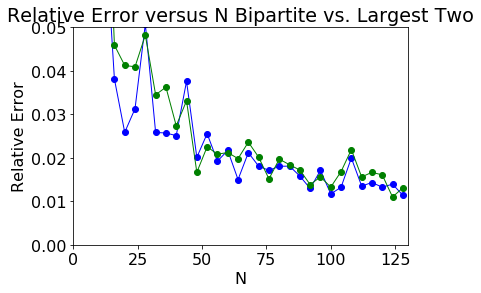

In [52]:
run = 1

if run:
#     test_bipartite_v_largest_two("data/signal_and_noise_16.txt")
#     test_bipartite_v_largest_two("data/signal_and_noise_64.txt")
    print(test_bipartite_v_largest_two("data/signal_and_noise_128.txt"))